In [1]:
import json
import shutil
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import select, BinaryExpression, func

from big5_databases.databases.db_models import DBPost
from big5_databases.databases.external import DBConfig, SQliteConnection
from big5_databases.databases.platform_db_mgmt import PlatformDB
from src.const import BASE_DATA_PATH

stats_copy_path = BASE_DATA_PATH / "stats_copy.sqlite"
from dataclasses import field
from collections import Counter
from datetime import date
from big5_databases.databases.external import ClientTaskConfig
from calendar import monthrange
from datetime import datetime, time
import pytz

In [2]:


def make_stats_copy(db_path: Path):
    shutil.copy(db_path, stats_copy_path)


make_stats_copy(BASE_DATA_PATH / "twitter_20_01_2025_backup.sqlite")

# old..
platform_db = PlatformDB(stats_copy_path, DBConfig(db_connection=SQliteConnection(db_path=stats_copy_path)))

db = platform_db.db_mgmt


# todo use misc.helper
def get_posts(platform: str,
              conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
              ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(
            func.date(DBPost.date_created).label('day'),
            func.count().label('count')
        ).group_by(
            func.date(DBPost.date_created)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        result = session.execute(query)
        return result.all()

2025-02-03 09:05:02,310 - ...Databases.databases.db_mgmt - DEBUG - creating db engine with sqlite:////home/rsoleyma/projects/platforms-clients/data/stats_copy.sqlite


In [3]:
def get_year_counts(year: int) -> pd.Series:
    results = get_posts("twitter",
                        conditions=DBPost.date_created.between(
                            datetime(year, 1, 1),
                            datetime(year + 1, 1, 1)
                        ))

    # Convert to pandas Series with days as index
    counts = pd.Series({row[0]: row[1] for row in results})
    return counts

def get_year_month_counts(year: int, month: int) -> pd.Series:
    results = get_posts("twitter",
                        conditions=DBPost.date_created.between(
                            datetime(year, month, 1),
                            datetime(year , month + 1, 1)
                        ))

    # Convert to pandas Series with days as index
    counts = pd.Series({row[0]: row[1] for row in results})
    return counts

#get_year_month_counts(2023)

In [4]:
import matplotlib.dates as mdates


def plot_daily_items(daily_counts: pd.Series, bars: bool = False):
    plt.figure(figsize=(12, 6))

    # Convert index to datetime if not already
    if not isinstance(daily_counts.index, pd.DatetimeIndex):
        daily_counts.index = pd.to_datetime(daily_counts.index)


    if bars:
        plt.bar(daily_counts.index, daily_counts.values,
                color='blue', label='Posts', alpha=0.7)
    else:
        sns.lineplot(data=daily_counts, color='blue', label='Posts')

    # Zero days highlight in red
    zero_days = daily_counts[daily_counts == 0]
    if not zero_days.empty:
        if bars:
            plt.bar(zero_days.index, zero_days.values,
                    color='red', label='No Posts',
                    zorder=5)
        else:
            plt.scatter(zero_days.index, zero_days.values,
                color='red', s=10, label='No Posts',
                zorder=5)

    plt.title('Daily Post Count (Red Bars = No Posts)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')

    # Improved x-axis labels
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.grid(True, alpha=0.3)
    # plt.legend()
    plt.tight_layout()
    return plt


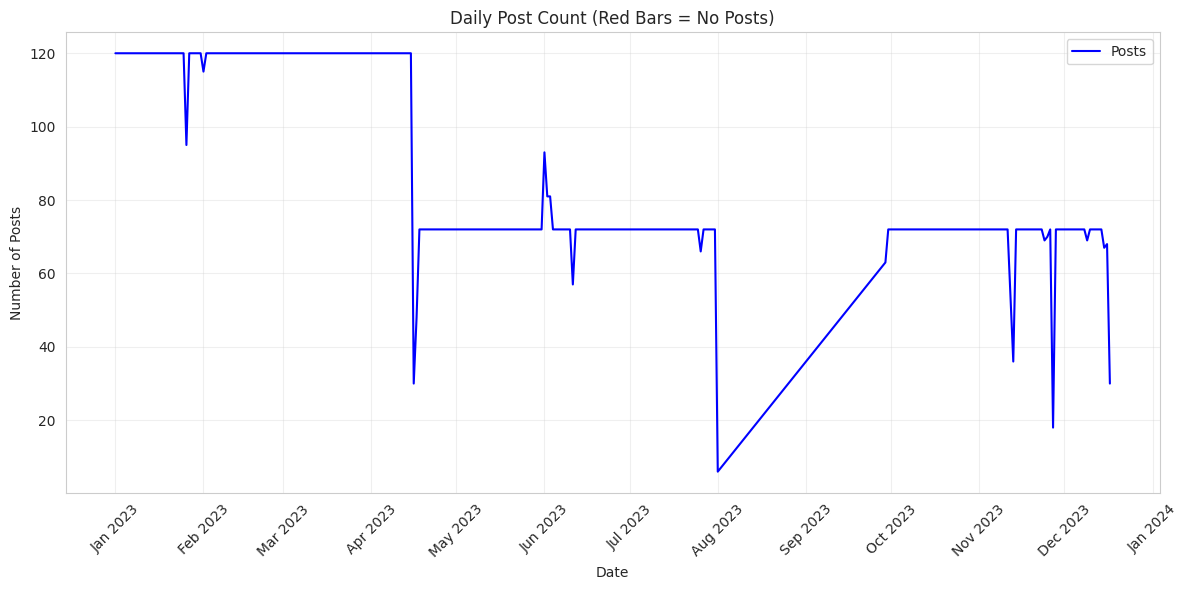

In [5]:
yc_2023 = get_year_counts(2023)
plot = plot_daily_items(yc_2023)
plot.show()


# yc_m_2023 = get_year_month_counts(2023,1)
# plot = plot_daily_items(yc_m_2023)
# plot.show()
# yc_m_2023

In [40]:
from big5_databases.databases.db_models import DBCollectionTask
from sqlalchemy.orm import contains_eager


# todo use misc.helper
def get_posts_w_task(platform: str,
                     conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
                     ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost, DBCollectionTask).join(
            DBCollectionTask,
            DBPost.collection_task_id == DBCollectionTask.id
        ).options(
            contains_eager(DBPost.collection_task)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        res = session.execute(query).all()
        return [(post.model(), post_col_task.model()) for post, post_col_task in res]

# jan_2022 = get_posts_w_task("youtube", conditions=DBPost.date_created.between(
#     datetime(2022, 1, 1),
#     datetime(2022, 2, 1)
# ))

# SQLITE QUERY
# date_created BETWEEN '2023-01-26 14:00:00' AND '2023-01-26 15:00:00'

In [41]:
def get_all_posts_sorted(platform: str,
                         conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
                         ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost)

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        query.order_by(DBPost.date_created)
        # Execute the query and return the results
        result = session.execute(query)
        for post in result.scalars():
            yield post.model()


In [42]:

@dataclass
class PostDayCollection:
    day: date
    hour_counts: Counter[int, int] = field(default_factory=Counter)

    def add_post(self, post_hour: int):
        self.hour_counts[post_hour] += 1

    def all_hours(self) -> bool:
        return len(day.hour_counts) == 24

    def is_full(self, min_count: int = 3) -> bool:
        return all(count >= min_count for count in self.hour_counts.values())

    def get_incomplete_hours(self, min_count: int = 3) -> list[int]:
        incomplete_hours = []
        for h in range(0, 24):
            if self.hour_counts.get(h, 0) < min_count:
                incomplete_hours.append(h)
        return incomplete_hours


@dataclass
class PostCollectionCounts:
    year: int
    days: dict[date, PostDayCollection] = field(default_factory=dict)
    total_posts = 0

    def add_post(self, post: DBPost):
        post_date = post.date_created.date()
        if post_date.year != self.year:
            return  # Skip posts from other years
        post_hour = post.date_created.hour
        self.total_posts += 1
        if post_date not in self.days:
            self.days[post_date] = PostDayCollection(day=post_date)
        self.days[post_date].add_post(post_hour)

    def get_incomplete_days(self, min_count: int) -> list[tuple[date, list[int]]]:
        incomplete_day_hours: list[tuple[date, list[int]]] = []
        for day in self.days.values():
            incomplete_hours = day.get_incomplete_hours(min_count)
            if incomplete_hours:
                incomplete_day_hours.append((day.day, incomplete_hours))
        return incomplete_day_hours

    @property
    def get_all_hours(self):
        return sum(len(day.hour_counts) for day in self.days.values())

YEAR = 2023
collection = PostCollectionCounts(YEAR)

all_posts = get_all_posts_sorted("twitter")
for post in all_posts:
    collection.add_post(post)
#
incomplete_days = collection.get_incomplete_days(3)
print(incomplete_days)
# print(collection.get_all_hours)


[(datetime.date(2023, 11, 27), [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]), (datetime.date(2023, 12, 17), [21]), (datetime.date(2023, 12, 27), [18, 23]), (datetime.date(2023, 12, 29), [9]), (datetime.date(2023, 12, 30), [4])]


In [33]:
# sorted(collection.days[date(2023, 1, 26)].hour_counts.items())

In [35]:
all_tasks = []
idx = 0

for incomplete_day, hours in incomplete_days:
    for hour in hours:
        # Create datetime with UTC timezone
        start_time = datetime.combine(incomplete_day, time(hour, 2), tzinfo=pytz.UTC)
        end_time = datetime.combine(incomplete_day, time(hour, 58), tzinfo=pytz.UTC)

        start_iso = start_time.isoformat()
        end_iso = end_time.isoformat()
        task = ClientTaskConfig.model_validate({
            "platform": "twitter",
            "task_name": f"twitter_2023_final_fix_3_{str(idx)}",
            "collection_config": {
                "query": "",
                "lang": "en",
                "filter_replies": True,
                "filter_quotes": True,
                "limit": 3,
                "from_time": start_iso,
                "to_time": end_iso,
            }
        })
        idx += 1
        all_tasks.append(task)


json.dump(
    [
        t.model_dump(exclude_unset=False, exclude_none=True, exclude_defaults=True) for t in all_tasks
    ],
    (BASE_DATA_PATH / "tasks/twitter_2023_missing.json").open("w", encoding="utf-8"))
# all_tasks[0]

In [9]:

# find missing days of a year
collection.days.keys()

for month in range(1, 13):
# get days of month
    days = monthrange(YEAR, month)[1]
d = date(YEAR, month, days)
if not d in collection.days:
    print(d)
# for day in :
#     if date(2023, month, day) not in collection.days:
#         print(month, day)

In [9]:
for day in collection.days.values():
    min_ = math.inf
max_ = 0
for h, hour_c in day.hour_counts.items():
    min_ = min(min_, hour_c)
max_ = max(max_, hour_c)
if hour_c < 3:
    print(day.day, h, hour_c)
    #print(day.day, min_,max_)

2023-11-25 14 1
2023-12-15 21 1
2023-12-16 15 2
2023-12-19 8 1
2023-12-19 15 1
2023-12-19 22 2
2023-12-21 11 1
2023-12-22 3 2
2023-12-22 4 1
2023-12-22 6 1
2023-12-24 5 1
2023-12-24 9 2
2023-12-24 11 1
2023-12-25 0 2
2023-12-25 1 1
2023-12-25 20 2
2023-12-25 21 2
2023-12-25 23 2
2023-12-26 11 1
2023-12-27 3 1
2023-12-27 10 2
2023-12-27 13 2
2023-12-28 0 1
2023-12-29 3 2
2023-12-29 8 2
2023-12-30 4 1
2023-12-30 9 2
2023-12-30 12 1
2023-12-30 15 2
2023-12-30 20 2
